Exploring Movie and Web Series Choices with IMDb Data

Rohan Javed 21l-5625

M.Talha Imran 21l-5657

M.Mashhood Husnain 21l-5651

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import base64
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
import time
from selenium.webdriver.common.by import By
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import ast
from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px
from collections import Counter
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score

C:\Users\Mashhood\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Scrapping

Functions required for the scrapping of data

In [2]:
def load_data(url, driver_path, interact, scrolls, loadSleep):
    
    if interact:
        
        SCROLL_DOWN = "window.scrollTo(0, document.body.scrollHeight);"
        service = Service(driver_path)
        driver = webdriver.Chrome(service=service)
        driver.get(url)
        time.sleep(loadSleep)
        
        load_button = driver.find_element(
            By.XPATH,
            "//button[contains(@class, 'ipc-see-more__button')]"
        )
    
        for i in range(0, scrolls):
            print("Scrolling down...")
            driver.execute_script(SCROLL_DOWN)
            time.sleep(2)
            load_button.click()
            time.sleep(10)
        
        ret = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()
    else:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        ret = BeautifulSoup(requests.get(url, headers=headers).content, 'html.parser') 
        
    return ret

def get_TitleCode(HTML_CONTENT, imdb_movie_title_code):
    href = HTML_CONTENT.find_all(
        'div',
        class_="ipc-title ipc-title--base ipc-title--title ipc-title-link-no-icon ipc-title--on-textPrimary sc-479faa3c-9 dkLVoC dli-title"
    )
    for href in href:
        imdb_movie_title_code.append(href.find('a')['href'].split('/')[2])

def get_Name(CONTENT, movie_names):
    
    name = CONTENT.find(
        'span',
        class_="sc-7f1a92f5-1 benbRT"
    )
    movie_names.append(name.text)
    print("DONE", end=" ")

def get_UserRating(CONTENT, movie_ratings):
    rating = CONTENT.find(
        'span',
        class_='sc-bde20123-1 cMEQkK'
    )
    movie_ratings.append(float(rating.text))
    print("DONE", end=" ")
    
def get_Release(CONTENT, movie_release_date):
    date = CONTENT.find_all(
        'a',
        class_='ipc-link ipc-link--baseAlt ipc-link--inherit-color'
    )
    movie_release_date.append(date[5].text)
    print("DONE", end=" ")

def get_MetaScore(CONTENT, movie_metascore):
    score = CONTENT.find(
        'span',
        class_='sc-b0901df4-0 bcQdDJ metacritic-score-box'
    )
    if score:
        movie_metascore.append(int(score.text))
    else:
        movie_metascore.append(np.nan)
    print("DONE", end=" ")
    
def get_Duration(CONTENT, movie_duration):
    time = CONTENT.find_all(
        'li',
        class_='ipc-inline-list__item'
    )
    movie_duration.append(time[6].text)
    print("DONE", end=" ")

def get_Genre(CONTENT, movie_genres):
    gen = CONTENT.find_all(
        'a',
        class_='ipc-chip ipc-chip--on-baseAlt'
    )
    gen_ = []
    for g in gen:
        gen_.append(g.text)
        
    movie_genres.append(gen_)
    print("DONE", end=" ")

def get_Director(CONTENT, movie_directors):
    dir_ = CONTENT.find(
        'a',
        class_='ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link'
    )
    movie_directors.append(dir_.text)
    print("DONE", end=" ")

def get_Star(CONTENT, movie_stars):
    str_ = CONTENT.find_all(
        'ul',
        class_='ipc-inline-list ipc-inline-list--show-dividers ipc-inline-list--inline ipc-metadata-list-item__list-content baseAlt'
    )
    
    stars = []
    for s in str_[2]:
       stars.append(s.text)
    
    movie_stars.append(stars)
    print("DONE", end=" ")

def get_review(TITLE_CODE, movie_reviews):
    review_url = f'https://www.imdb.com/title/{TITLE_CODE}/reviews?spoiler=hide&sort=reviewVolume&dir=desc&ratingFilter=0'
    soup = BeautifulSoup(requests.get(review_url).content, 'html.parser')
    review = soup.find_all('a', class_='title')
    movie_reviews.append([r.text for r in review])
    print("DONE", end=" ")

def convertMin(text):
    pattern = re.compile(r'(?:(?P<hours>\d+)h)? ?(?:(?P<minutes>\d+)m)?')
    match = pattern.match(text)
    
    hours = int(match.group('hours')) if match.group('hours') else 0
    minutes = int(match.group('minutes')) if match.group('minutes') else 0
    if hours == 0 and minutes == 0:
        return np.nan
    else:
        return hours * 60 + minutes

def convert_to_numeric(value):
    try:
        return int(value)
    except (ValueError, TypeError):
        return np.nan

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return " ".join(filtered_text)


Constant Variables Initialization

In [5]:
DRIVER_PATH = "A:\chromedriver-win64\chromedriver.exe"
URL_MOVIES = 'https://www.imdb.com/search/title/?sort=user_rating,asc&groups=top_1000&count=250'

HTML_TITLECODE = load_data(
    URL_MOVIES,
    DRIVER_PATH,
    interact=True,
    scrolls=3,
    loadSleep=5
)


Scrolling down...
Scrolling down...
Scrolling down...


In [17]:
# Scrapping the data from the website

imdb_movie_title_code = []
movie_names = []
movie_reviews = []
movie_user_ratings = []
movie_release_date = []
movie_metascore = []
movie_duration_time = []
movie_genres = []
movie_directors = []
movie_stars = []

# getting title codes for each movie to be used in the url
get_TitleCode(HTML_TITLECODE, imdb_movie_title_code)

for code, i in zip(imdb_movie_title_code, range(0, len(imdb_movie_title_code))):
    IND_MOV_URL = f'https://www.imdb.com/title/{code}/?ref_=tt_urv'
    
    # getting the HTML of each movie page
    HTML_CONTENT = load_data(
        IND_MOV_URL,
        DRIVER_PATH,
        interact=False,
        loadSleep=5
    )
    
    # getting the data from the HTML
    get_Name(HTML_CONTENT, movie_names)
    get_UserRating(HTML_CONTENT, movie_user_ratings)
    get_Release(HTML_CONTENT, movie_release_date)
    get_MetaScore(HTML_CONTENT, movie_metascore)
    get_Duration(HTML_CONTENT, movie_duration_time)
    get_Genre(HTML_CONTENT, movie_genres)
    get_Director(HTML_CONTENT, movie_directors)
    get_Star(HTML_CONTENT, movie_stars)
    get_review(code, movie_reviews)
    
    print(f'\nFinished for {i + 1}: [{code}]')

    

DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 1: [tt0241527]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 2: [tt7131622]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 3: [tt0144084]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 4: [tt0093870]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 5: [tt0387564]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 6: [tt0119116]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 7: [tt0416449]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 8: [tt0409459]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 9: [tt0088680]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 10: [tt0829482]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 11: [tt2582782]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 12: [tt5463162]
DONE DONE DONE DONE DONE DONE DONE DONE DONE 
Finished for 13: [tt0151804]
DONE DONE DONE DONE DONE DONE DONE

In [ ]:
# storing the data in a dataframe and converting it to an excel file

dataframe = {
    'Name': movie_names,
    'Title Code': imdb_movie_title_code,
    'Release Year': movie_release_date,
    'Duration': movie_duration_time,
    'Genre': movie_genres,
    'Rating': movie_user_ratings,
    'MetaScore': movie_metascore,
    'Directors': movie_directors,
    'Stars': movie_stars,
    'Reviews': movie_reviews,
}

pd.DataFrame(dataframe).to_excel('1000_IMDB_Movies.xlsx', index=False)


In [6]:
# df = pd.read_excel('1000_IMDB_Movies_Cleaned.xlsx')
# movie_names = df['Name'].tolist()
# imdb_movie_title_code = df['Title Code'].tolist()
# movie_release_date = df['Release Year'].tolist()
# movie_duration_time = df['Duration'].tolist()
# movie_genres = df['Genre'].tolist()
# movie_ratings = df['Rating'].tolist()
# movie_metascore = df['MetaScore'].tolist()
# movie_directors = df['Directors'].tolist()
# movie_stars = df['Stars'].tolist()
# movie_reviews = df['Reviews'].tolist()

Data Wrangling

In [3]:
df = pd.read_excel('1000_IMDB_Movies.xlsx')
df

,Name,Title Code,Release Year,Duration,Genre,Rating,MetaScore,Directors,Stars,Reviews
0,Harry Potter and the Sorcerer's Stone,tt0241527,2001,2h 32m,"['Adventure', 'Family', 'Fantasy']",7.6,65.0,Chris Columbus,"['Daniel Radcliffe', 'Rupert Grint', 'Richard ...","[' Great fun!\n', ' Great chemistry set up for..."
1,Once Upon a Time in... Hollywood,tt7131622,2019,2h 41m,"['Comedy', 'Drama']",7.6,83.0,Quentin Tarantino,"['Leonardo DiCaprio', 'Brad Pitt', 'Margot Rob...",[' Really good...up until the incredibly blood...
2,American Psycho,tt0144084,2000,1h 42m,"['Crime', 'Drama', 'Horror']",7.6,64.0,Mary Harron,"['Christian Bale', 'Justin Theroux', 'Josh Luc...","[' useful\n', ' American Psycho\n', ' Behind t..."
3,RoboCop,tt0093870,1987,1h 42m,"['Action', 'Crime', 'Sci-Fi']",7.6,70.0,Paul Verhoeven,"['Peter Weller', 'Nancy Allen', ""Dan O'Herlihy""]","[' Fun 80s icon\n', ' Classic Action in Gory D..."
4,Saw,tt0387564,2004,1h 43m,"['Horror', 'Mystery', 'Thriller']",7.6,46.0,James Wan,"['Cary Elwes', 'Leigh Whannell', 'Danny Glover']","[' A puzzling game worth playing\n', ' convolu..."
...,...,...,...,...,...,...,...,...,...,...
995,The Godfather Part II,tt0071562,1974,3h 22m,"['Crime', 'Drama']",9.0,90.0,Francis Ford Coppola,"['Al Pacino', 'Robert De Niro', 'Robert Duvall']",[' My review of this film is pretty unimportan...
996,The Lord of the Rings: The Return of the King,tt0167260,2003,3h 21m,"['Action', 'Adventure', 'Drama']",9.0,94.0,Peter Jackson,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell...","[' Pretty much outstanding\n', ' awards winnin..."
997,12 Angry Men,tt0050083,1957,1h 36m,"['Crime', 'Drama']",9.0,97.0,Sidney Lumet,"['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam']","[' Brilliant, brilliant, brilliant!!\n', ' A V..."
998,The Godfather,tt0068646,1972,2h 55m,"['Crime', 'Drama']",9.2,100.0,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan']","["" #2 on IMDb's Top 100, a multi-Oscar-winner ..."


In [4]:
#converting the data to the required format
df['Release Year'] = df['Release Year'].apply(convert_to_numeric)
df['Duration'] = df['Duration'].apply(convertMin).astype('Int64')

# getting info about the dataframe
print(df.shape, end="\n"*2)
print(df.dtypes, end="\n"*2)
print(df.isnull().sum(), end="\n"*2)
print(df.info(), end="\n"*2)

# filling missing values with the mode and mean as the data is rich
df['Release Year'].fillna(df['Release Year'].mode().values[0], inplace=True)
df['Duration'].fillna(int(df['Duration'].mean()), inplace=True)
df['MetaScore'].fillna(df['MetaScore'].mean(), inplace=True)
df['Reviews'] = df['Reviews'].apply(ast.literal_eval)
df['Genre'] = df['Genre'].apply(ast.literal_eval)

# checking if the missing values are filled
print(df.info())


(1000, 10)

Name             object
Title Code       object
Release Year    float64
Duration          Int64
Genre            object
Rating          float64
MetaScore       float64
Directors        object
Stars            object
Reviews          object
dtype: object

Name              0
Title Code        0
Release Year     16
Duration         34
Genre             0
Rating            0
MetaScore       155
Directors         0
Stars             0
Reviews           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1000 non-null   object 
 1   Title Code    1000 non-null   object 
 2   Release Year  984 non-null    float64
 3   Duration      966 non-null    Int64  
 4   Genre         1000 non-null   object 
 5   Rating        1000 non-null   float64
 6   MetaScore     845 non-null    float64
 7   Directors     1000 no

In [5]:
# processing the reviews by removing stopwords etc
df['Reviews'] = df['Reviews'].apply(lambda x: [remove_stopwords(i) for i in x])

# remove non alphanumeric characters and convert to lowercase
df['Reviews'] = df['Reviews'].apply(lambda x: [re.sub(r'[^A-Za-z0-9 ]+', '', i) for i in x])
df['Reviews'] = df['Reviews'].apply(lambda x: [i.lower() for i in x])

In [ ]:
# generating a report of the data containing visualizations and statistics
profile = ProfileReport(df)
profile.to_file("IMDB_Movies_Report.html")

One Hot Encoding the genre column

In [6]:
# Create an instance of MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Apply one-hot encoding and create a new DataFrame
encoded_genres = pd.DataFrame(mlb.fit_transform(df['Genre']), columns=mlb.classes_)

# Concatenate the new DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_genres], axis=1)

In [2]:
# dropping the columns that are not required
df_encoded.drop(['Title Code', 'Genre'], axis=1, inplace=True)

df_encoded['Review Sentiments'] = review_sentiments_col

# saving to an excel file
df_encoded.to_excel('1000_IMDB_Movies_Cleaned.xlsx', index=False)
df_encoded

,Name,Release Year,Duration,Rating,MetaScore,Directors,Stars,Reviews,Action,Adventure,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Review Sentiments
0,Harry Potter and the Sorcerer's Stone,2001,152,7.6,65.0,Chris Columbus,"['Daniel Radcliffe', 'Rupert Grint', 'Richard ...","['great fun ', 'great chemistry set rest serie...",0,1,...,0,0,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
1,Once Upon a Time in... Hollywood,2019,161,7.6,83.0,Quentin Tarantino,"['Leonardo DiCaprio', 'Brad Pitt', 'Margot Rob...",['really good incredibly bloody awful ending ...,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
2,American Psycho,2000,102,7.6,64.0,Mary Harron,"['Christian Bale', 'Justin Theroux', 'Josh Luc...","['useful', 'american psycho', 'behind mask', '...",0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
3,RoboCop,1987,102,7.6,70.0,Paul Verhoeven,"['Peter Weller', 'Nancy Allen', ""Dan O'Herlihy""]","['fun 80s icon', 'classic action gory detail',...",1,0,...,0,0,0,0,1,0,0,0,0,"[1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."
4,Saw,2004,103,7.6,46.0,James Wan,"['Cary Elwes', 'Leigh Whannell', 'Danny Glover']","['a puzzling game worth playing', 'convoluted ...",0,0,...,0,0,1,0,0,0,1,0,0,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,The Godfather Part II,1974,202,9.0,90.0,Francis Ford Coppola,"['Al Pacino', 'Robert De Niro', 'Robert Duvall']","['my review film pretty unimportant ', 'one be...",0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, ..."
996,The Lord of the Rings: The Return of the King,2003,201,9.0,94.0,Peter Jackson,"['Elijah Wood', 'Viggo Mortensen', 'Ian McKell...","['pretty much outstanding', 'awards winning ep...",1,1,...,0,0,0,0,0,0,0,0,0,"[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, ..."
997,12 Angry Men,1957,96,9.0,97.0,Sidney Lumet,"['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam']","['brilliant brilliant brilliant ', 'a very ...",0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, ..."
998,The Godfather,1972,175,9.2,100.0,Francis Ford Coppola,"['Marlon Brando', 'Al Pacino', 'James Caan']",[' 2 imdb s top 100 multioscarwinner 1500 rev...,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, ..."


In [8]:
df = pd.read_excel('1000_IMDB_Movies_Cleaned.xlsx')
df['Reviews'] = df['Reviews'].apply(ast.literal_eval)
df['Review Sentiments'] = df['Review Sentiments'].apply(ast.literal_eval)

X = []
y = []

for rev, revs in zip(df['Reviews'], df['Review Sentiments']):
    for r, rs in zip(rev, revs):
        X.append(r)
        y.append(rs)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TF-IDF MODEL

In [10]:
# Initialize the CountVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert the result to an array
tfidf_matrix_train = X_train_tfidf.toarray()
tfidf_matrix_test = X_test_tfidf.toarray()

feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Print the TF-IDF matrix
print("TF-IDF Matrix: ", tfidf_matrix_train)
print("Feature Names (TF-IDF): ", feature_names_tfidf)

TF-IDF Matrix:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Feature Names (TF-IDF):  ['007' '03' '05' ... 'zulus' 'zviagintsev' 'zwartboek']


BOW Model

In [11]:
# Initialize the CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Convert the result to an array
bow_matrix_train = X_train_bow.toarray()
bow_matrix_test = X_test_bow.toarray()

# Get the feature names (words)
feature_names_bow = bow_vectorizer.get_feature_names_out()

# Print the Bag of Words model
print("Bag of Words: ", bow_matrix_train)
print("Feature Names(BOW): ", feature_names_bow)

Bag of Words:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names(BOW):  ['007' '10' '100' ... 'zombies' 'zone' 'zulu']


BI-GRAM Model

In [12]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

bigram_matrix_train = X_train_bigram.toarray()
bigram_matrix_test = X_test_bigram.toarray()

feature_names_bigram = bigram_vectorizer.get_feature_names_out()

print("Bigram: ", bigram_matrix_train)
print("Feature Names(Bigram): ", feature_names_bigram)

Bigram:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names(Bigram):  ['007 adventures' '05 best' '10 10' ... 'zulu warriors' 'zulus vs'
 'zwartboek black']


MACHINE LEARNING

Applying Logistic Regression for TF-IDF model

In [13]:
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

predictions = classifier.predict(X_test_tfidf)

mse_tfidf = mean_squared_error(y_test, predictions)
f1_tfidf = f1_score(y_test, predictions)
recall_tfidf = recall_score(y_test, predictions)
precision_tfidf = precision_score(y_test, predictions)
accuracy_tfidf = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy_tfidf * 100:.2f}%')
print(f'Mean Squared Error: {mse_tfidf:.4f}')
print(f'F1 Score: {f1_tfidf:.4f}')
print(f'Recall: {recall_tfidf:.4f}')
print(f'Precision: {precision_tfidf:.4f}')
print(f'Confusion Matrix: \n{conf_matrix}')


Accuracy: 91.37%
Mean Squared Error: 0.0863
F1 Score: 0.9146
Recall: 0.8870
Precision: 0.9439
Confusion Matrix: 
[[2258  137]
 [ 294 2307]]


Applying Logistic Regression for BOW model

In [14]:
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

predictions = classifier.predict(X_test_bow)

mse_bow = mean_squared_error(y_test, predictions)
f1_bow = f1_score(y_test, predictions)
recall_bow = recall_score(y_test, predictions)
precision_bow = precision_score(y_test, predictions)
accuracy_bow = accuracy_score(y_test, predictions)
conf_matrix_bow = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy_bow * 100:.2f}%')
print(f'Mean Squared Error: {mse_bow:.4f}')
print(f'F1 Score: {f1_bow:.4f}')
print(f'Recall: {recall_bow:.4f}')
print(f'Precision: {precision_bow:.4f}')
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 93.45%
Mean Squared Error: 0.0655
F1 Score: 0.9360
Recall: 0.9200
Precision: 0.9526
Confusion Matrix: 
[[2258  137]
 [ 294 2307]]


Applying Logistic Regression for BI-GRAM model

In [15]:

classifier = LogisticRegression()
classifier.fit(X_train_bigram, y_train)

predictions = classifier.predict(X_test_bigram)

mse_bigram = mean_squared_error(y_test, predictions)
f1_bigram = f1_score(y_test, predictions)
recall_bigram = recall_score(y_test, predictions)
precision_bigram = precision_score(y_test, predictions)
accuracy_bigram = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy_bigram * 100:.2f}%')
print(f'Mean Squared Error: {mse_bigram:.4f}')
print(f'F1 Score: {f1_bigram:.4f}')
print(f'Recall: {recall_bigram:.4f}')
print(f'Precision: {precision_bigram:.4f}')
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 70.02%
Mean Squared Error: 0.2998
F1 Score: 0.6334
Recall: 0.4975
Precision: 0.8714
Confusion Matrix: 
[[2204  191]
 [1307 1294]]


BOW gives a better accuracy than TF-IDF

DEEP LEARNING

ANN for TF-IDF model

In [17]:
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    tfidf_matrix_train, y_train, test_size=0.2, random_state=42
)

# Convert data to NumPy arrays
X_train_split_np = np.array(X_train_split)
y_train_split_np = np.array(y_train_split)
X_val_split_np = np.array(X_val_split)
y_val_split_np = np.array(y_val_split)

# Build the ANN model
model = Sequential()

model.add(Dense(
    256,
    input_dim=tfidf_matrix_train.shape[1],
    activation='relu'
    )
) # fully connected layer with model shape as input and 256 nodes for first hidden layer

model.add(Dropout(0.3)) # prevent overfitting (30% of nodes will be dropped randomly)

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3)) # prevent overfitting (30% of nodes will be dropped randomly)

model.add(Dense(1, activation='softmax')) # output layer with 1 node for binary classification

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # look at validation loss to determine when to stop training
    patience=3, # stop after 3 epochs with no improvement
    restore_best_weights=True # restore to best weights after stopping
) # stops the model when there is no major improvement to prevent overfitting


# Train the model with the training and validation sets
batch_size = 32
epochs = 5

history = model.fit(
    X_train_split_np,
    y_train_split_np,
    epochs=epochs,
    batch_size=batch_size, # no.of smaples taken in each gradient decent update
    validation_data=(X_val_split_np, y_val_split_np), # validation data to check the performance of the model
    callbacks=[early_stopping], # stop training when there is no major improvement
)

predictions_tfidf = model.predict(tfidf_matrix_test)
binary_predictions_tfidf = (predictions_tfidf > 0.5).astype(int)

loss_tfidf, accuracy_tfidf_ann = model.evaluate(tfidf_matrix_test, np.array(y_test))
recall_tfidf_ann = recall_score(y_test, binary_predictions_tfidf)
precision_tfidf_ann = precision_score(y_test, binary_predictions_tfidf)
f1_tfidf_ann = f1_score(y_test, binary_predictions_tfidf)

print(f'Test Accuracy: {accuracy_tfidf_ann * 100:.2f}%')
print(f'Recall: {recall_tfidf_ann:.4f}')
print(f'Precision: {precision_tfidf_ann:.4f}')
print(f'F1 Score: {f1_tfidf_ann:.4f}')
print(f'Test Loss: {loss_tfidf:.4f}')

Epoch 1/5
500/500 [==============================] - 27s 51ms/step - loss: 0.3612 - accuracy: 0.8432 - val_loss: 0.2597 - val_accuracy: 0.9024
Epoch 2/5
500/500 [==============================] - 25s 50ms/step - loss: 0.1182 - accuracy: 0.9606 - val_loss: 0.2857 - val_accuracy: 0.8919
Epoch 3/5
500/500 [==============================] - 25s 49ms/step - loss: 0.0569 - accuracy: 0.9823 - val_loss: 0.3201 - val_accuracy: 0.8939
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.2528 - accuracy: 0.9031
Test Accuracy: 90.31%
Recall: 0.9266
Precision: 0.8916
F1 Score: 0.9087
Test Loss: 0.2528


ANN for BOW model

In [19]:
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    bow_matrix_train, y_train, test_size=0.2, random_state=42
)

# Convert your data to NumPy arrays
X_train_split_np = np.array(X_train_split)
y_train_split_np = np.array(y_train_split)
X_val_split_np = np.array(X_val_split)
y_val_split_np = np.array(y_val_split)

# Build the ANN model
model = Sequential()
model.add(Dense(
    256,
    input_dim=bow_matrix_train.shape[1],
    activation='relu'
    )
)
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with the training and validation sets
batch_size = 32
epochs = 5

history = model.fit(
    X_train_split_np,
    y_train_split_np,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_split_np, y_val_split_np),
    callbacks=[early_stopping],
)

predictions_bow = model.predict(bow_matrix_test)
binary_predictions_bow = (predictions_bow > 0.5).astype(int)

loss_bow, accuracy_bow_ann = model.evaluate(bow_matrix_test, np.array(y_test))
recall_bow_ann = recall_score(y_test, binary_predictions_bow)
precision_bow_ann = precision_score(y_test, binary_predictions_bow)
f1_bow_ann = f1_score(y_test, binary_predictions_bow)

print(f'Test Accuracy: {accuracy_bow_ann * 100:.2f}%')
print(f'Recall: {recall_bow_ann:.4f}')
print(f'Precision: {precision_bow_ann:.4f}')
print(f'F1 Score: {f1_bow_ann:.4f}')
print(f'Test Loss: {loss_bow:.4f}')

Epoch 1/5
500/500 [==============================] - 8s 16ms/step - loss: 0.3448 - accuracy: 0.8551 - val_loss: 0.2471 - val_accuracy: 0.9167
Epoch 2/5
500/500 [==============================] - 8s 15ms/step - loss: 0.1338 - accuracy: 0.9571 - val_loss: 0.2465 - val_accuracy: 0.9212
Epoch 3/5
500/500 [==============================] - 8s 16ms/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 0.2926 - val_accuracy: 0.9182
Epoch 4/5
500/500 [==============================] - 8s 17ms/step - loss: 0.0398 - accuracy: 0.9897 - val_loss: 0.3417 - val_accuracy: 0.9212
Epoch 5/5
157/157 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9273
Test Accuracy: 92.73%
Recall: 0.9208
Precision: 0.9385
F1 Score: 0.9296
Test Loss: 0.2264


ANN for BI-GRAM model

In [20]:
model = Sequential()

model.add(Dense(
    256,
    input_dim=bigram_matrix_train.shape[1],
    activation='relu'
    )
)

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
epochs = 5

model.fit(
    bigram_matrix_train,
    np.array(y_train),
    epochs=epochs,
    batch_size=batch_size
)

predictions_bigram = model.predict(bigram_matrix_test)
binary_predictions_bigram = (predictions_bigram > 0.5).astype(int)

loss_bigram, accuracy_bigram_ann = model.evaluate(bigram_matrix_test, np.array(y_test))
recall_bigram_ann = recall_score(y_test, binary_predictions_bigram)
precision_bigram_ann = precision_score(y_test, binary_predictions_bigram)
f1_bigram_ann = f1_score(y_test, binary_predictions_bigram)

print(f'Test Accuracy: {accuracy_bigram_ann * 100:.2f}%')
print(f'Recall: {recall_bigram_ann:.4f}')
print(f'Precision: {precision_bigram_ann:.4f}')
print(f'F1 Score: {f1_bigram_ann:.4f}')
print(f'Test Loss: {loss_bigram:.4f}')

Epoch 1/5
625/625 [==============================] - 116s 185ms/step - loss: 0.6026 - accuracy: 0.6528
Epoch 2/5
625/625 [==============================] - 112s 179ms/step - loss: 0.1227 - accuracy: 0.9499
Epoch 3/5
625/625 [==============================] - 114s 183ms/step - loss: 0.0536 - accuracy: 0.9699
Epoch 4/5
625/625 [==============================] - 109s 174ms/step - loss: 0.0505 - accuracy: 0.9700
Epoch 5/5
157/157 [==============================] - 3s 20ms/step - loss: 0.8411 - accuracy: 0.7104
Test Accuracy: 71.04%
Recall: 0.5602
Precision: 0.8278
F1 Score: 0.6682
Test Loss: 0.8411


Model Comparisons (Logistic Regression)

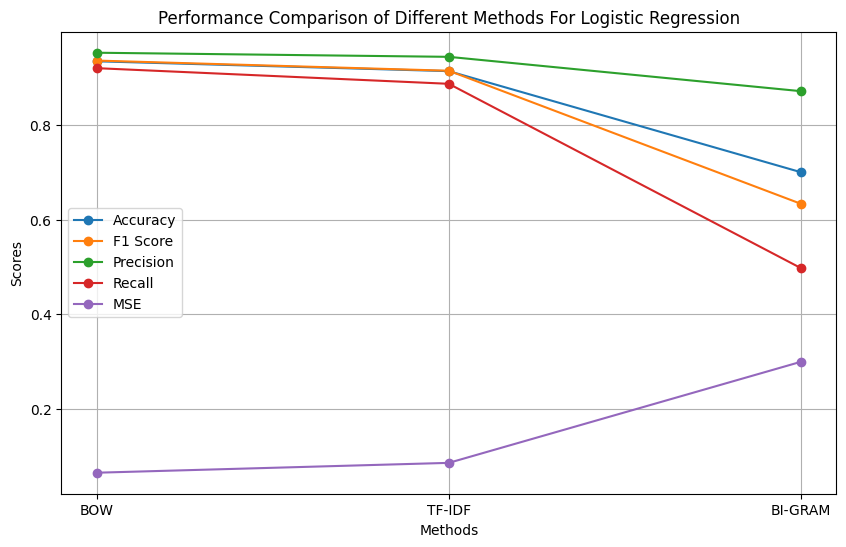

In [21]:
# Assuming you have lists or arrays containing metrics for each method
methods = ['BOW', 'TF-IDF', 'BI-GRAM']
accuracy_scores = [accuracy_bow, accuracy_tfidf, accuracy_bigram]
f1_scores = [f1_bow, f1_tfidf, f1_bigram]
precision_scores = [precision_bow, precision_tfidf, precision_bigram]
recall_scores = [recall_bow, recall_tfidf, recall_bigram]
mse_scores = [mse_bow, mse_tfidf, mse_bigram]

# Plotting the metrics over different methods
plt.figure(figsize=(10, 6))

plt.plot(methods, accuracy_scores, marker='o', label='Accuracy')
plt.plot(methods, f1_scores, marker='o', label='F1 Score')
plt.plot(methods, precision_scores, marker='o', label='Precision')
plt.plot(methods, recall_scores, marker='o', label='Recall')
plt.plot(methods, mse_scores, marker='o', label='MSE')

plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Performance Comparison of Different Methods For Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


Model Comparisons (ANN)

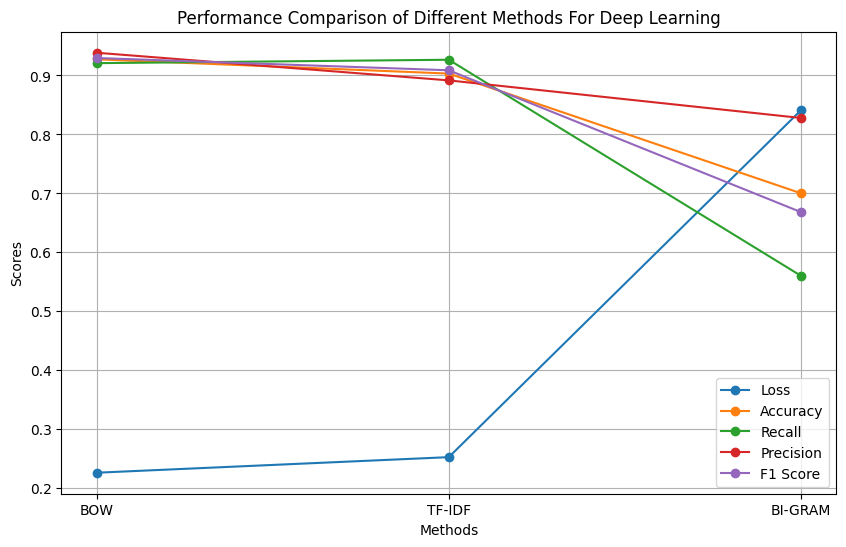

In [22]:
losess = [loss_bow, loss_tfidf, loss_bigram]
accuracies = [accuracy_bow_ann, accuracy_tfidf_ann, accuracy_bigram]
recalls = [recall_bow_ann, recall_tfidf_ann, recall_bigram_ann]
precisions = [precision_bow_ann, precision_tfidf_ann, precision_bigram_ann]
f1s = [f1_bow_ann, f1_tfidf_ann, f1_bigram_ann]

plt.figure(figsize=(10, 6))

plt.plot(methods, losess, marker='o', label='Loss')
plt.plot(methods, accuracies, marker='o', label='Accuracy')
plt.plot(methods, recalls, marker='o', label='Recall')
plt.plot(methods, precisions, marker='o', label='Precision')
plt.plot(methods, f1s, marker='o', label='F1 Score')

plt.xlabel('Methods')
plt.ylabel('Scores')
plt.title('Performance Comparison of Different Methods For Deep Learning')

plt.legend()
plt.grid(True)
plt.show()

VISUALIZATIONS

Text(0.5, 1.0, 'Top 10 Movies by Rating')

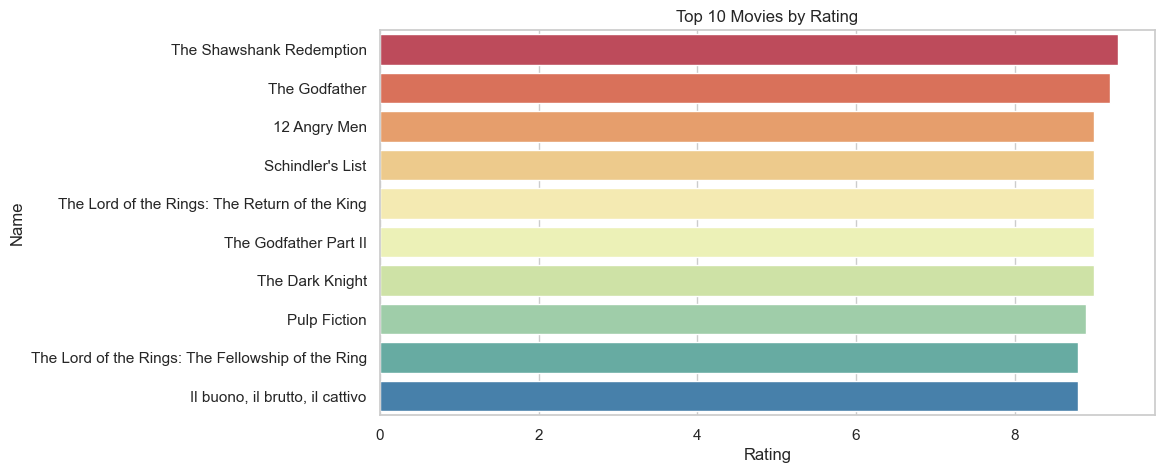

In [82]:
df = pd.read_excel('1000_IMDB_Movies_Cleaned.xlsx')

sorted_df = df.sort_values(by=['Rating', 'MetaScore'], ascending=False, inplace=False)
top_10 = sorted_df.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Rating', y='Name', data=top_10, palette='Spectral')
plt.title('Top 10 Movies by Rating')


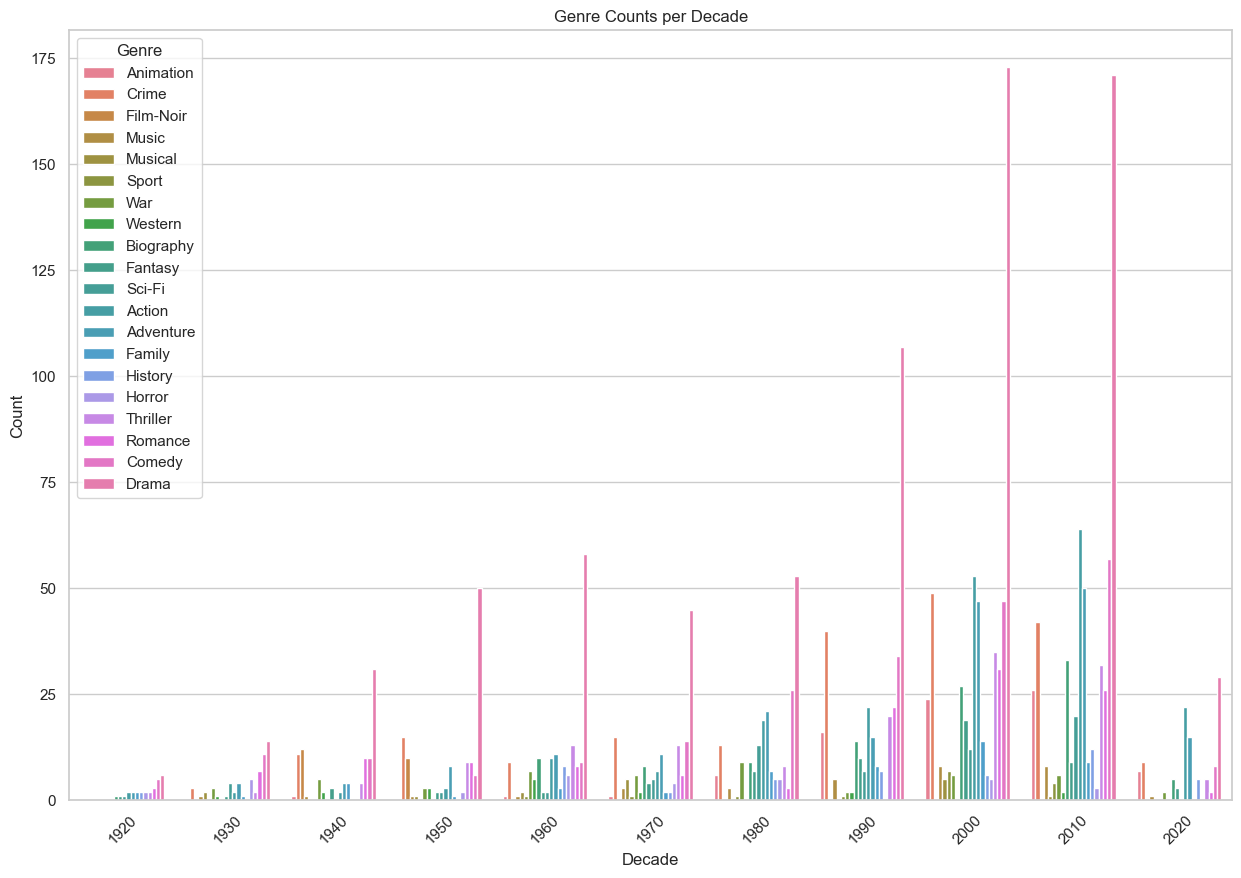

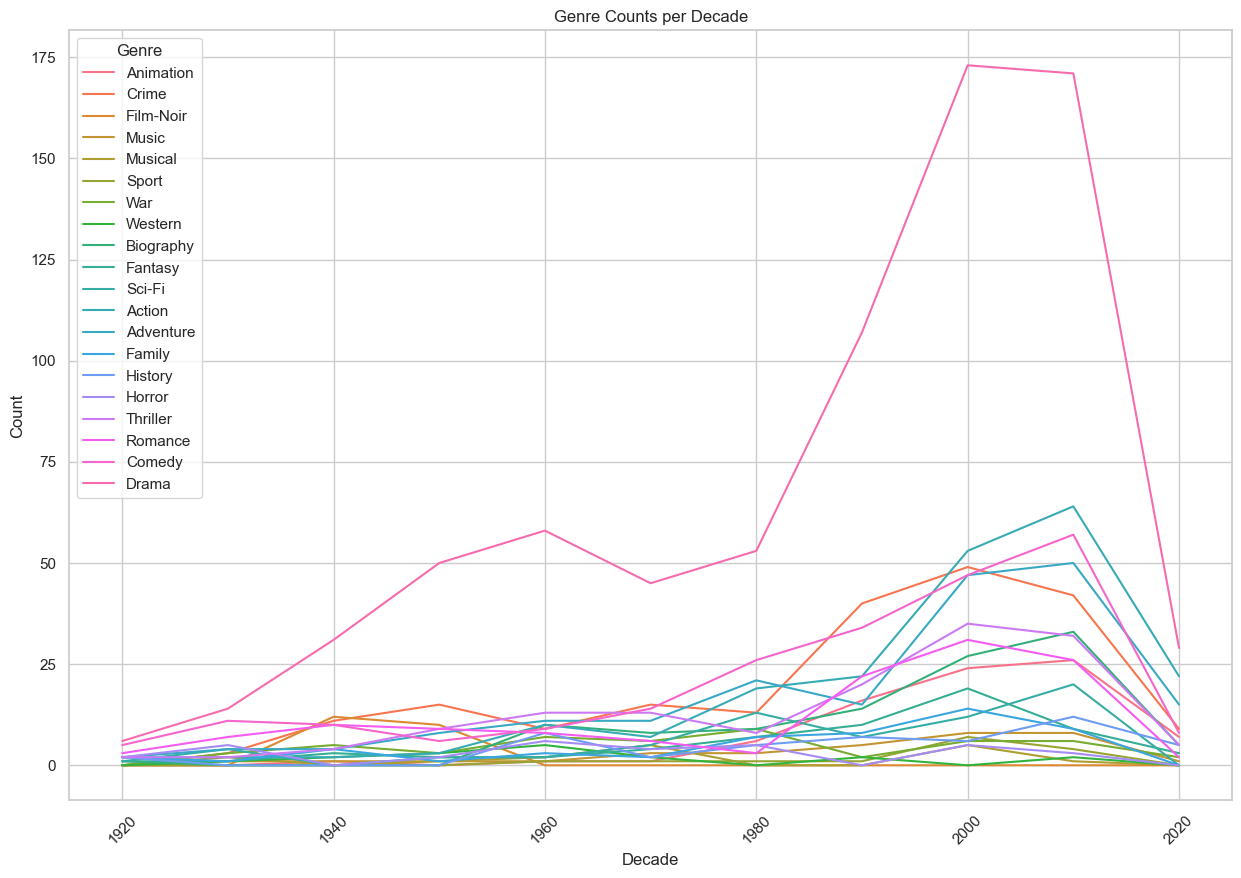

In [27]:
df['decade'] = (df['Release Year'] // 10) * 10

genre_counts_per_decade = df.groupby('decade').agg({
    'Action': 'sum',
    'Adventure': 'sum',
    'Animation': 'sum',
    'Biography': 'sum',
    'Comedy': 'sum',
    'Crime': 'sum',
    'Drama': 'sum',
    'Family': 'sum',
    'Fantasy': 'sum',
    'Film-Noir': 'sum',
    'History': 'sum',
    'Horror': 'sum',
    'Music': 'sum',
    'Musical': 'sum',
    'Romance': 'sum',
    'Sci-Fi': 'sum',
    'Sport': 'sum',
    'Thriller': 'sum',
    'War': 'sum',
    'Western': 'sum',
    
}).reset_index()

sns.set(style="whitegrid")

# Reshape the DataFrame for countplot
df_counts = genre_counts_per_decade.melt(id_vars='decade', var_name='Genre', value_name='Count')
df_counts.sort_values(by=['decade', 'Count'], ascending=True, inplace=True)

# Define a color palette with enough distinct colors for each genre
genre_palette = sns.color_palette("husl", n_colors=len(df_counts['Genre'].unique()))

# Create a countplot with separate colors for each genre
plt.figure(figsize=(15, 10))
sns.barplot(x='decade', y='Count', hue='Genre', data=df_counts, palette=genre_palette)
plt.title('Genre Counts per Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Create a line plot with separate colors for each genre
plt.figure(figsize=(15, 10))
sns.lineplot(x='decade', y='Count', hue='Genre', data=df_counts, palette=genre_palette)
plt.title('Genre Counts per Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


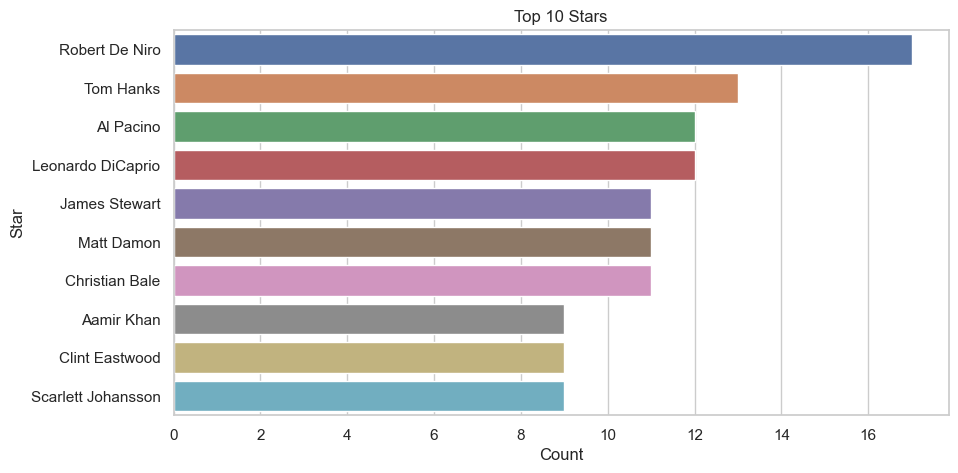

In [78]:
#count the appearance of each star
s = df['Stars'].apply(ast.literal_eval).explode()
counts = Counter(s)
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=False)
sorted_counts.reverse()

#plot the top 10 stars
plt.figure(figsize=(10, 5))
sns.barplot(x=[i[1] for i in sorted_counts[:10]], y=[i[0] for i in sorted_counts[:10]])
plt.title('Top 10 Stars')
plt.xlabel('Count')
plt.ylabel('Star')
plt.show()


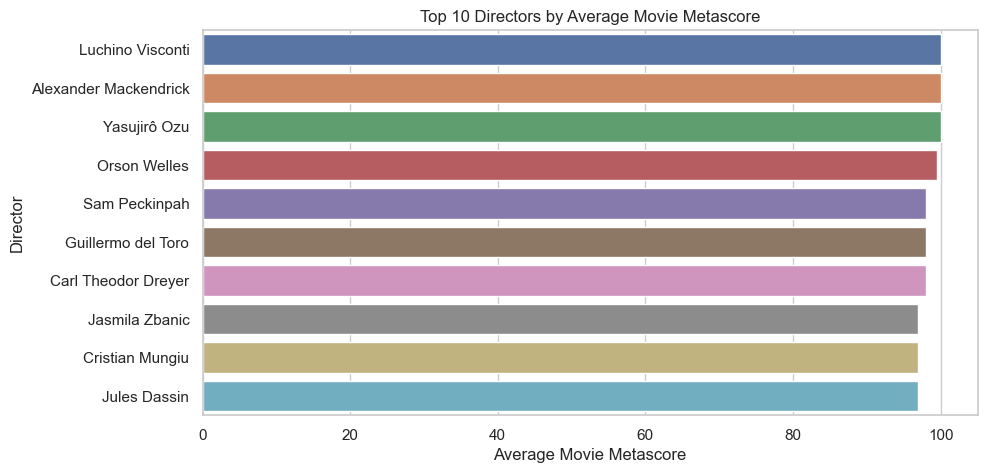

In [95]:
# Average movie Metascore of each director
df_directors = df.groupby('Directors')['MetaScore'].mean().reset_index()
df_directors.sort_values(by='MetaScore', ascending=False, inplace=True)

# Plot the top 10 directors
plt.figure(figsize=(10, 5))
sns.barplot(x='MetaScore', y='Directors', data=df_directors.head(10))
plt.title('Top 10 Directors by Average Movie Metascore')
plt.xlabel('Average Movie Metascore')
plt.ylabel('Director')
plt.show()


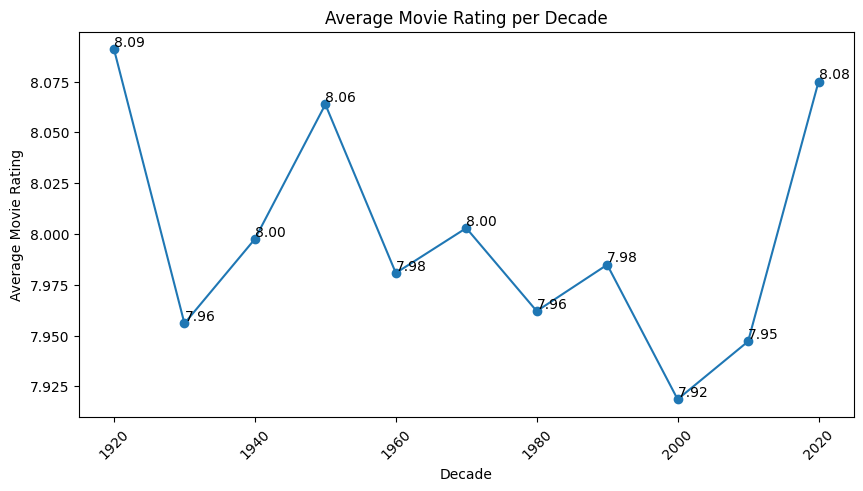

In [62]:
df['decade'] = (df['Release Year'] // 10) * 10
df_decade = df.groupby('decade').agg({
    'Rating': 'mean',
    'MetaScore': 'mean',
    'Duration': 'mean',
    'Reviews': 'sum'
}).reset_index()

# Plot the average movie rating per decade
plt.figure(figsize=(10, 5))
plt.plot('decade', 'Rating', data=df_decade, marker='o')

# Add annotations with y-coordinate only
for i, row in df_decade.iterrows():
    plt.text(row['decade'], row['Rating'], f'{row["Rating"]:.2f}', ha='left', va='bottom')

plt.title('Average Movie Rating per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Movie Rating')
plt.xticks(rotation=45)
plt.show()

In [82]:
df['year'] = df['Release Year']
df_year = df.groupby('year').agg({
    'Rating': 'max',
    'Name': 'first'
}).reset_index()

fig = px.scatter(df_year, x='year', y='Rating', title='Movie with the Highest Rating Each Year',
                 labels={'Rating': 'Movie Rating', 'year': 'Year'},
                 template='plotly_white', hover_data=['Name'])

fig.update_traces(marker=dict(size=10, color='blue', line=dict(width=2, color='DarkSlateGray')))

fig.write_html('Movie with the Highest Rating Each Year.html')